# On-The-Fly Noise Augmentation

#### Packages

In [17]:
import os
import sys
import glob
import time
import h5py
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import signal

from gwpy.timeseries import TimeSeries
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.types import TimeSeries as TS

In [2]:
from pycbc import DYN_RANGE_FAC

## Using O3a/O3b Glitches obtained from Gravity Spy

### Get glitches from GWOSC using Gravity Spy glitch start times

In [2]:
sample_length = 60.0 # in seconds
low_freq_cutoff = 15.0 # Hz
sanity_plot = False

In [3]:
def downsample(strain, sample_rate=2048., crop=2.5):
    res = resample_to_delta_t(strain, 1./sample_rate)
    ret = highpass(res, low_freq_cutoff).astype(np.float32)
    ret = ret.time_slice(float(ret.start_time) + crop,
                         float(ret.end_time) - crop)
    return ret

def get_glitch_data(args):
    try:
        idx, csv = args
        ref_time = np.random.uniform(0.0, sample_length)
        gps = csv['event_time'][idx]
        # We pad 2.5 seconds on each side to be removed after downsampling
        start = int(gps) - ref_time - 2.5
        end = int(gps) + (sample_length - ref_time) + 2.5
        #start = int(gps) - 1 - 2.5
        #end = int(gps) + H1_O3a['duration'][idx] + 1 + 2.5
        glitch = TimeSeries.fetch_open_data(csv['ifo'][idx], start, end, cache=1)
        #original_glitch = glitch.value[int(2.5*(1./glitch.dt.value)):int(len(glitch.value)-2.5*(1./glitch.dt.value))]
        data = TS(glitch.value, delta_t=glitch.dt.value)
        data = downsample(data).numpy()
        #dur = sample_length
        #time_original = np.linspace(0.0, dur, int(dur*(1./glitch.dt.value)))
        #time_downsampled = np.linspace(0.0, dur, int(dur*2048.))
        return data
    except:
        return None


def fetcher(cnum, limit, size):

    chunk_num = cnum
    print('chunk num = {}, idx = {} to {}, size = {}'.format(cnum, limit, limit+size, size))
    try:
        H1_O3a = pd.read_csv('L1_O3b.csv')[limit:limit+size]
    except:
        sys.exit('chunk too small')

    glitches = []

    bad_counter = 0
    with mp.Pool(processes=64) as pool:
        with tqdm(total=len(H1_O3a['ifo'])) as pbar:
            pbar.set_description("MP-Glitch Retrieval GWOSC-GWSPY")
            for glitch in pool.imap_unordered(get_glitch_data, [(idx, H1_O3a) for idx in range(limit, limit+size)]):
                if isinstance(glitch, np.ndarray):
                    glitches.append(glitch)
                else:
                    bad_counter+=1
                pbar.update()

                if sanity_plot:
                    raise NotImplemented('Return values of function incomplete!')
                    if isinstance(glitch, np.ndarray):
                        glitches.append(glitch)
                        plt.figure(figsize=(16.0, 6.0), dpi=300)
                        plt.plot(to, oglitch/max(oglitch), label='original')
                        plt.plot(td, glitch/max(glitch), label='downsampled')
                        plt.legend()
                        plt.grid(which='both')
                        plt.savefig('glitch.png')

                        plt.figure(figsize=(16.0, 6.0), dpi=300)
                        f, t, Sxx = signal.spectrogram(glitch, fs=2048.)
                        plt.pcolormesh(t, f, Sxx, shading='gouraud')
                        plt.ylabel('Frequency [Hz]')
                        plt.xlabel('Time [sec]')
                        plt.savefig('spectrogram_downsampled_glitch.png')

                        plt.figure(figsize=(16.0, 6.0), dpi=300)
                        f, t, Sxx = signal.spectrogram(oglitch, fs=4096.)
                        plt.pcolormesh(t, f, Sxx, shading='gouraud')
                        plt.ylabel('Frequency [Hz]')
                        plt.xlabel('Time [sec]')
                        plt.savefig('spectrogram_original_glitch.png')
                        raise

            print('Bad samples (not collected) = {}'.format(bad_counter))
            glitches = np.array(glitches).astype(np.float32)
            with h5py.File('./glitch_L1_O3b_chunk_{}.hdf'.format(chunk_num), 'a') as hf:
                hf.create_dataset('data', data=glitches, compression="gzip", chunks=True)

In [ ]:
# Check if saved glitches file has valid data
"""
lookup_table = "./glitch_H1_O3a_chunk_2.hdf"
with h5py.File(lookup_table, 'a') as fp:
    glitch_data = np.array(fp['data'][:])
    print(glitch_data.shape)
raise
"""

In [ ]:
# Writing down a bash code to run the above fetcher
"""
#!/bin/bash
counter=1
batch_size=1000
for limit in {0..80000..1000}; do
    python3 check.py $counter $limit $batch_size
    ((counter++))
done;
"""

In [ ]:
counter=1
batch_size=1000
for limit in range(0, 80000, 1000):
    fetcher(counter, limit, batch_size)
    counter+=1

## Fetch O3b Noise Data from GWOSC

In [3]:
low_freq_cutoff = 15.0 # Hz

In [5]:
def downsample(strain, sample_rate=2048., crop=2.5):
    res = resample_to_delta_t(strain, 1./sample_rate)
    ret = highpass(res, low_freq_cutoff).astype(np.float32)
    ret = ret.time_slice(float(ret.start_time) + crop,
                         float(ret.end_time) - crop)
    return ret

def get_detector_noise(args):
    n, left_boundary, right_boundary, detector = args
    success = False
    while not success:
        try:
            noise_data = TimeSeries.fetch_open_data(detector, left_boundary, right_boundary, cache=1)
            success = True
        except:
            duration = right_boundary - left_boundary
            left_boundary += 0.1 * duration
            right_boundary -= 0.1 * duration
            if (right_boundary - left_boundary) < 3600:
                break

    if success:
        data = TS(noise_data.value, delta_t=noise_data.dt.value)
        data = downsample(data).numpy() * DYN_RANGE_FAC
        data = data.astype(np.float32)
        return (n, data)
    else:
        return (n, None)

def fetcher(GPS_boundaries, num_workers=16, detector=""):
    detector_noise = []
    print('Fetching GWOSC data for detector {} using {} cores'.format(detector, num_workers))
    # Download data at each GPS range
    with mp.Pool(processes=num_workers) as pool:
        with tqdm(total=len(GPS_boundaries)) as pbar:
            pbar.set_description("MP-DET_NOISE GWOSC")
            for out in pool.imap_unordered(get_detector_noise, [(n, foo[0], foo[1], detector) for n, foo in enumerate(GPS_boundaries)]):
                n, data = out
                if isinstance(data, np.ndarray):
                    with h5py.File('/local/scratch/igr/nnarenraju/O3b_real_noise/noise_{}_O3b_chunk_{}.hdf'.format(detector, n), 'a') as hf:
                        hf.create_dataset('data', data=data, compression="gzip", chunks=True)
                pbar.update()

In [6]:
# Link: https://gwosc.org/eventapi/html/allevents/
all_events_list = np.genfromtxt('./O3b/all_events_list.txt', skip_header=1)
# Link: https://gwosc.org/timeline/show/O3b_4KHZ_R1/H1_DATA*L1_DATA*V1_DATA/1256655618/12708000/
# DATA flag was included and none of the flags {CBC_CAT1, CBC_CAT2, CBC_HW_INJ, or BURST_HW_INJ} were included
# Data collected only for O3b
H1_O3b_GPS = np.loadtxt('./O3b/H1_O3b_GPS.txt')
L1_O3b_GPS = np.loadtxt('./O3b/L1_O3b_GPS.txt')

In [7]:
all_events_GPS = np.sort(all_events_list[:,4])
H1_O3b_ranges = list(zip(H1_O3b_GPS[:,0], H1_O3b_GPS[:,1]))
L1_O3b_ranges = list(zip(L1_O3b_GPS[:,0], L1_O3b_GPS[:,1]))

In [8]:
event_buffer = 30 # seconds
minimum_segment_duration = 3600 # seconds (1 hour)
minimum_minisegment_duration = 60 # seconds

In [9]:
H1_O3b_GPS_boundaries = []

for n, (H1_O3b_start, H1_O3b_end) in enumerate(H1_O3b_ranges):
    if H1_O3b_end - H1_O3b_start <= minimum_segment_duration:
        continue 
    event_idxs = np.array([H1_O3b_start <= GPS_time <= H1_O3b_end for GPS_time in all_events_GPS]).nonzero()[0]
    if len(event_idxs):
        print('Event present between GPS times {} and {} with duration = {} s'.format(H1_O3b_start, H1_O3b_end, H1_O3b_end-H1_O3b_start))
        # All event times present in the given segment
        invalid_GPS_times = all_events_GPS[event_idxs]
        # Removing 30 seconds on either side of an event
        windows = [[iGPStime-event_buffer, iGPStime+event_buffer] for iGPStime in invalid_GPS_times]

        if len(windows) > 1:
            # combine overlapping windows and remove bad boundaries
            # Remember: the event GPS sorted are sorted
            boundaries = [H1_O3b_start]
            for n in np.arange(1, len(windows)):
                # if left boundary of first window is greater than segment start time
                # Segment start time already added to combined windows
                if n==1 and windows[n-1][0] > H1_O3b_start:
                    boundaries.append(windows[n-1][0])
                # if left boundary of current window overlaps with right boundary of previous window
                if windows[n][0] > windows[n-1][1]:
                    boundaries.extend([windows[n-1][1], windows[n][0]])
                # if right boundary of last window is less than segment end time
                if n == len(windows)-1 and windows[n][1] < H1_O3b_end:
                    boundaries.append(windows[n][1])
        else:
            boundaries = [H1_O3b_start]
            if windows[0][0] > H1_O3b_start:
                boundaries.append(windows[0][0])
            if windows[0][1] < H1_O3b_end:
                boundaries.append(windows[0][1])
        
        # Add segment boundary
        boundaries.append(H1_O3b_end)
        boundaries = np.array(boundaries)

        # Check if any mini-segment within the given segment is below a threshold in duration
        # Every two subsequent boundaries must now be valid minisegments within the given segment
        # There should always be an equal number of boundaries within the variable (if it works as intended)
        assert len(boundaries) % 2 == 0
        split_boundaries = np.array_split(boundaries, len(boundaries) / 2)
        split_boundaries = np.array([foo for foo in split_boundaries if foo[1]-foo[0] > minimum_minisegment_duration])

        # All valid boundaries
        H1_O3b_GPS_boundaries.extend(split_boundaries)
    
    else:
        # If there are no events in the given segment
        boundary = np.array([H1_O3b_start, H1_O3b_end])
        H1_O3b_GPS_boundaries.append(boundary)

total_valid_duration = 0
for boundary in H1_O3b_GPS_boundaries:
    total_valid_duration += boundary[1]-boundary[0]
print("Total valid duration = {} days".format(total_valid_duration/(3600*24)))

Event present between GPS times 1256774748.0 and 1256838392.0 with duration = 63644.0 s
Event present between GPS times 1256977384.0 and 1257002021.0 with duration = 24637.0 s
Event present between GPS times 1257657505.0 and 1257698798.0 with duration = 41293.0 s
Event present between GPS times 1258785203.0 and 1258818347.0 with duration = 33144.0 s
Event present between GPS times 1258840747.0 and 1258891562.0 with duration = 50815.0 s
Event present between GPS times 1259040545.0 and 1259071940.0 with duration = 31395.0 s
Event present between GPS times 1259479311.0 and 1259528407.0 with duration = 49096.0 s
Event present between GPS times 1260433875.0 and 1260572984.0 with duration = 139109.0 s
Event present between GPS times 1260755941.0 and 1260859341.0 with duration = 103400.0 s
Event present between GPS times 1261013054.0 and 1261025795.0 with duration = 12741.0 s
Event present between GPS times 1261085612.0 and 1261153129.0 with duration = 67517.0 s
Event present between GPS time

In [10]:
# Sanity check (This should not produce anything)
for n, (H1_O3b_start, H1_O3b_end) in enumerate(H1_O3b_GPS_boundaries):
    event_idxs = np.array([H1_O3b_start <= GPS_time <= H1_O3b_end for GPS_time in all_events_GPS]).nonzero()[0]
    if len(event_idxs):
        print('Event present between GPS times {} and {} with duration = {} s'.format(H1_O3b_start, H1_O3b_end, H1_O3b_end-H1_O3b_start))

In [ ]:
fetcher(H1_O3b_GPS_boundaries, num_workers=4, detector='H1')

#### Sanity check for downloaded O3b noise data

In [15]:
# Check if downloaded noise looks fine
H1_filename = "/local/scratch/igr/nnarenraju/O3b_real_noise/H1/noise_H1_O3b_chunk_0.hdf"
L1_filename = "/local/scratch/igr/nnarenraju/O3b_real_noise/L1/noise_L1_O3b_chunk_0.hdf"

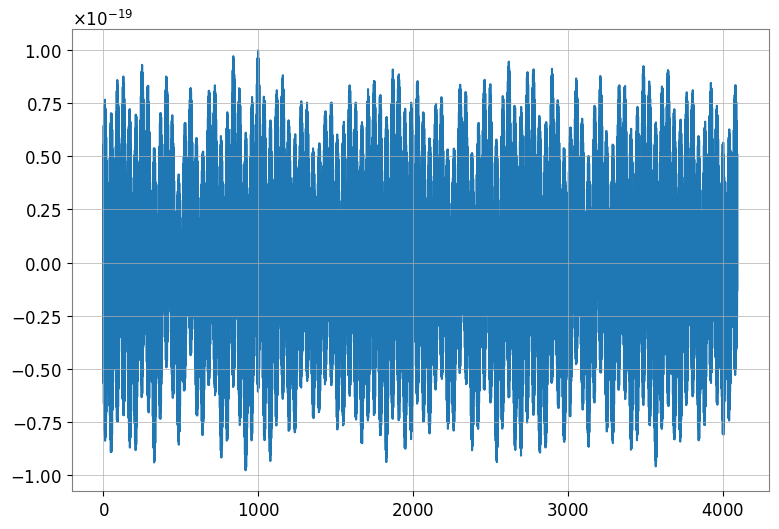

In [16]:
hf = h5py.File(H1_filename)
idx = 0
noise = np.array(hf['data'][idx:idx+4096]).astype(np.float64) / DYN_RANGE_FAC

plt.figure(figsize=(9.0, 6.0))
plt.plot(noise)
plt.show()

### Save all file lengths for quick loading during OTF

In [1]:
import os
import glob
import h5py
import numpy as np

H1_O3a_dirname="/local/scratch/igr/nnarenraju/gwspy/H1_O3a_glitches" 
L1_O3a_dirname="/local/scratch/igr/nnarenraju/gwspy/L1_O3a_glitches"
H1_O3b_dirname="/local/scratch/igr/nnarenraju/gwspy/H1_O3b_glitches" 
L1_O3b_dirname="/local/scratch/igr/nnarenraju/gwspy/L1_O3b_glitches"
   
# Glitch data files
"""
print('H1_O3a')
glitch_files_H1_O3a = [h5py.File(fname) for fname in glob.glob(os.path.join(H1_O3a_dirname, "*.hdf"))]
num_glitches_H1_O3a = [len(np.array(hf['data'][:])) for hf in glitch_files_H1_O3a]
np.save("./tmp/h1_o3a.npy", num_glitches_H1_O3a)

print('L1_O3a')
glitch_files_L1_O3a = [h5py.File(fname) for fname in glob.glob(os.path.join(L1_O3a_dirname, "*.hdf"))]
num_glitches_L1_O3a = [len(np.array(hf['data'][:])) for hf in glitch_files_L1_O3a]
np.save("./tmp/l1_o3a.npy", num_glitches_L1_O3a)
"""
print('H1_O3b')
glitch_files_H1_O3b = [h5py.File(fname) for fname in glob.glob(os.path.join(H1_O3b_dirname, "*.hdf"))]
num_glitches_H1_O3b = [len(np.array(hf['data'][:])) for hf in glitch_files_H1_O3b]
np.save("./tmp/H1_O3b.npy", num_glitches_H1_O3b)

print('L1_O3b')
glitch_files_L1_O3b = [h5py.File(fname) for fname in glob.glob(os.path.join(L1_O3b_dirname, "*.hdf"))]
num_glitches_L1_O3b = [len(np.array(hf['data'][:])) for hf in glitch_files_L1_O3b]
np.save("./tmp/L1_O3b.npy", num_glitches_L1_O3b)

H1_O3b
L1_O3b


In [18]:
H1_O3b_dirname="/local/scratch/igr/nnarenraju/O3b_real_noise/H1" 
L1_O3b_dirname="/local/scratch/igr/nnarenraju/O3b_real_noise/L1"
   
# Downloaded noise data
print('H1_O3b')
noise_files_H1_O3b = [h5py.File(fname) for fname in glob.glob(os.path.join(H1_O3b_dirname, "*.hdf"))]
duration_H1_O3b = [len(np.array(hf['data'][:])) for hf in noise_files_H1_O3b]
np.save("./tmp/durs_H1_O3b_all_noise.npy", duration_H1_O3b)

print('L1_O3b')
noise_files_L1_O3b = [h5py.File(fname) for fname in glob.glob(os.path.join(L1_O3b_dirname, "*.hdf"))]
duration_L1_O3b = [len(np.array(hf['data'][:])) for hf in noise_files_L1_O3b]
np.save("./tmp/durs_L1_O3b_all_noise.npy", duration_L1_O3b)

H1_O3b
L1_O3b


## Random Noise Slice from n-days of noise

In [ ]:
## The following can be directly integrated into transforms.py in ORChiD
# Use either method 1 or method 2 for loading durations
# NOTE: Method 1 seems to be slow sometimes
class RandomNoiseSlice():
    """ Used to augment the start time of noise samples from continuous noise .hdf file """
    # This will become the primary noise reading function
    def __init__(self, real_noise_path="", sample_length=17.0,
                 segment_llimit=None, segment_ulimit=None):
        self.sample_length = sample_length
        self.min_segment_duration = self.sample_length
        self.real_noise_path = real_noise_path
        self.segment_ends_buffer = 0.0 # seconds
        self.slide_buffer = 240.0
        self.dt = 1./2048.

        # Keep all required noise files open
        self.O3a_real_noise = h5py.File(self.real_noise_path, 'r')
        # Get detectors used
        self.detectors = ['H1', 'L1']
        # Get ligo segments and load_times from noise file
        ligo_segments, load_times = self._get_ligo_segments()
        # Get segment info and set probability of obtaining sample from segment
        self.psegment = {}
        segdurs = np.empty(len(ligo_segments), dtype=np.float64)
        # limit check
        if segment_ulimit == -1:
            segment_ulimit = len(ligo_segments)

        ### METHOD 1: Get signal durations before running pipeline ###
        psegment = {}
        for n, seg in enumerate(ligo_segments):
            key_time = str(load_times[seg][0])
            _key = f'{self.detectors[0]}/{key_time}'
            # Sanity check if _key is present in noise file
            try:
                _ = self.O3a_real_noise[_key]
            except:
                # An impossible segment duration and cond rand < segprob is never satisfied
                segdurs[n] = 0
                psegment[n] = [-1, -1, -1]
                continue
            
            # Set valid start and end times of given segment (not actual start time)
            # load_times[seg][0] is the same as seg[0]
            segment_length = len(np.array(self.O3a_real_noise[_key][:]))
            seg_start_idx = 0 + self.segment_ends_buffer
            seg_end_idx = segment_length - (self.sample_length + self.segment_ends_buffer)*(1./self.dt)
            # Get segment duration for calculating sampling ratio wrt all segments
            segdurs[n] = segment_length
            # Add the epoch parameter to store
            psegment[n] = [key_time, seg_start_idx, seg_end_idx]
        
        print(self.real_noise_path)
        
        ### METHOD 2: Pre-saved durations ###
        """
        lookup = np.load("./notebooks/tmp/segdurs_all.npy")
        for n, seg in enumerate(ligo_segments):
            key_time = str(load_times[seg][0])
            _key = f'{self.detectors[0]}/{key_time}'
            # Sanity check if _key is present in noise file
            if n >= segment_llimit and n <= segment_ulimit:
                segment_length = lookup[:,1][n]
                seg_start_idx = 0 + self.segment_ends_buffer
                seg_end_idx = segment_length - (self.sample_length + self.segment_ends_buffer)*(1./self.dt)
                segdurs[n] = lookup[:,1][n]
                self.psegment[n] = [key_time, seg_start_idx, seg_end_idx]
            else:
                # An impossible segment duration and cond rand < segprob is never satisfied
                segdurs[n] = 0
                self.psegment[n] = [-1, -1, -1]
        """
        
        # Get probabilties of using segment using segment durations
        seg_idx = np.arange(len(segdurs))
        segprob = list(segdurs/np.sum(segdurs))
        # Get one choice from seg_idx based on probalities obtained from seg durations
        self.segment_choice = lambda _: np.random.choice(seg_idx, 1, p=segprob)[0]

    def _load_segments(self):
        tmp_dir = "./tmp"
        path = os.path.join(tmp_dir, 'segments.csv')
        # Download data if it does not exist
        if not os.path.isfile(path):
            url = 'https://www.atlas.aei.uni-hannover.de/work/marlin.schaefer/MDC/segments.csv'
            response = requests.get(url)
            with open(path, 'wb') as fp:
                fp.write(response.content)

        # Load data from CSV file
        segs = ligo.segments.segmentlist([])
        with open(path, 'r') as fp:
            reader = csv.reader(fp)
            for i, row in enumerate(reader):
                if i == 0:
                    continue
                idx, start, end = row
                segs.append(ligo.segments.segment([int(start), int(end)]))

        return segs
    
    def _get_ligo_segments(self):
        # https://lscsoft.docs.ligo.org/ligo-segments/
        segments = self._load_segments()
        
        # Restrict segments
        ligo_segments = ligo.segments.segmentlist([])
        for seg in segments:
            start, end = seg
            segduration = end - start
            # Check if segment fulfills minimum duration requirements
            if self.min_segment_duration is not None and segduration - self.slide_buffer < self.min_segment_duration:
                continue
            ligo_segments.append(ligo.segments.segment([start, end]))
        
        # Refer link provided above to ligo-segments
        # Sort the elements of the list into ascending order, and merge continuous 
        # segments into single segments. Segmentlist is modified in place. 
        # This operation is O(n log n).
        ligo_segments.coalesce()

        # Get times from each valid segment
        load_times = {}
        for seg in ligo_segments:
            for rawseg in segments:
                if seg in rawseg:
                    load_times[seg] = rawseg
                    break;
            if seg not in load_times:
                raise RuntimeError
            
        return ligo_segments, load_times
    
    def _make_sample_start_time(self, seg_start_idx, seg_end_idx):
        # Make a sample start time that is uniformly distributed within segdur
        return int(np.random.uniform(low=seg_start_idx, high=seg_end_idx))

    def get_noise_segment(self, segdeets):
        ## Get noise sample from given O3a real noise segment
        noise = []
        for det, segdeet in zip(self.detectors, segdeets):
            key_time, seg_start_idx, seg_end_idx = segdeet
            # Get sample_start_time using segment times
            # This start time will lie within a valid segment time interval
            sample_start_idx = self._make_sample_start_time(seg_start_idx, seg_end_idx)
            # Get the required portion of given segment
            sidx = sample_start_idx
            eidx = sample_start_idx + int(self.sample_length / self.dt)
            # Which key does the current segment belong to in real noise file
            # key_time provided is the start time of required segment
            key = f'{det}/{key_time}'
            # Get time series from segment and apply the dynamic range factor
            ts = np.array(self.O3a_real_noise[key][sidx:eidx]).astype(np.float64)
            if "O3a_real_noise.hdf" in self.real_noise_path:
                ts /= DYN_RANGE_FAC
            noise.append(ts)
        
        # Convert noise into np.ndarray, suitable for other transformations
        noise = np.stack(noise, axis=0)
        return noise
    
    def pick_segment(self):
        # Pick a random segment to use based on probablities set using their duration
        # Picking two different segments and start times provides an extra layer of augmentation
        idx1 = self.segment_choice(0)
        idx2 = self.segment_choice(0)
        # Return the segment details of selected segment
        return (self.psegment[idx1], self.psegment[idx2])

    def apply(self):
        ## Get noise sample with random start time from O3a real noise
        # Toss a biased die and retrieve the segment to use
        segdeets = self.pick_segment()
        # Get noise sample with random start time (uniform within segment)
        noise = self.get_noise_segment(segdeets)
        # Return noise data
        return noise

## Noise Recolouring

In [ ]:
def recolour(self, ts, DET):
    ## Whiten the noise using old PSD and recolour using new PSD
    # Convert to frequency domain after windowing
    n = len(ts)
    delta_t = 1./self.fs
    data_fd = np.fft.rfft(ts)
    freq = np.fft.rfftfreq(n, delta_t)
    data_delta_f = freq[1] - freq[0]
    # Convert the PSD to new delta_f using PyCBC interpolate function
    old_psd = FrequencySeries(DET['old_psd'], delta_f=DET['old_delta_f'])
    old_psd = interpolate(old_psd, data_delta_f)
    # Whitening (Remove old PSD from data)
    whitened_signal = data_fd / np.sqrt(old_psd)
    # Convert the new PSDs to have delta_f similar to data
    new_psd = FrequencySeries(DET['new_psd'], delta_f=DET['old_delta_f'])
    new_psd = interpolate(new_psd, data_delta_f)
    # Recolour using new PSD and return to time domain
    recoloured = np.fft.irfft(whitened_signal*np.sqrt(new_psd))
    tmp = TimeSeries(recoloured, delta_t=1./self.fs)
    recoloured = pycbc_highpass(tmp, self.noise_low_freq_cutoff).astype(np.float64)
    # debug plotter
    if self.debug_me:
        _, recovered = scipy_welch(recoloured, fs=self.fs, nperseg=4.*self.fs, average='median')
        self.debug_recolour([old_psd, new_psd, ts, whitened_signal, recoloured, recovered],
                            ['old_psd', 'new_psd', 'original', 'white', 'recoloured', 'recovered_psd'])

    return recoloured.numpy()